In [1]:
# Jairo Andres Saavedra Alfonso
# 01 de Febrero de 2019
# Universidad de Los Andes
# Phycis 
######################__________________Weekly Report__________________######################
# Beta 1.0

In [2]:
#Packages
from astropy.io import fits
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import torch 
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torch.utils.data

!jupyter nbconvert --to python Weekly_Reports_CNN.ipynb

[NbConvertApp] Converting notebook Weekly_Reports_CNN.ipynb to python
[NbConvertApp] Writing 16797 bytes to Weekly_Reports_CNN.py


In [3]:
N_sample=40000

def Load_Files(file_1,file_2,N_sample,classification=True):
    hdul = fits.open(file_1) # Open file 1 -- 'truth_DR12Q.fits'
    info=hdul.info() # File info
    columns=hdul[1].columns # File Columns 
    print('INFO:',info,'/n',columns)
    data=hdul[1].data # Database of spectra with human-expert classifications 

    # Reading data from data_dr12.fits. This file had the spectra from data dr12. 
    hdul_2 = fits.open(file_2) # Open file 2 -- 'data_dr12.fits'
    info2=hdul_2.info() # File info 
    columns2=hdul_2[1].columns # File Columns
    print('INFO:',info2,'/n',columns2)
    data2=hdul_2[1].data # Database of spectra
    spectra=hdul_2[0].data # Spectrum of each object 
    
    # Subset of PLATE parameters of both data
    data_PLATE_1=data['PLATE']
    data_PLATE_2=data2['PLATE']

    # Subset of MJD parameters of both data
    data_MJD_1=data['MJD']
    data_MJD_2=data2['MJD']

    # Subset of FIBERID parameters of both data
    data_FIBERID_1=data['FIBERID']
    data_FIBERID_2=data2['FIBERID']
    data_ID_1=data['THING_ID']
    data_ID_2=data2['TARGETID']
    
    # The column 'CLASS_PERSON' have a class identifier for each spectrum: STARS=1, GALAXY=4, QSO=3 and QSO_BAL=30.
    C_P=data['CLASS_PERSON'] #Class Person column 
    STAR=C_P[C_P==1] # objects classified as stars
    GALAXY=C_P[C_P==4] # objects classified as galaxies 
    QSO=C_P[C_P==3] # objects classified as QSO (Quasars)
    QSO_BAL=C_P[C_P==30] # objects classified as QSO BAL (Quasars with Broad Absortions Lines)
    N_C=C_P[C_P!=30]   
    N_C=N_C[N_C!=3]
    N_C=N_C[N_C!=1]
    N_C=N_C[N_C!=4] # objects wrong classified
    print('Star:',STAR.shape)
    print('Galaxy:',GALAXY.shape)
    print('QSO:',QSO.shape)
    print('QSO BAL:',QSO_BAL.shape)
    print('NN:',N_C.shape)
    
    # I create two DataFrame for Superset_DR12Q and data_dr12 with only three parameters
    data1={'PLATE':data_PLATE_1,'MJD':data_MJD_1,'FIBERID':data_FIBERID_1,'ID':data_ID_1}
    data1=pd.DataFrame(data=data1)

    data2={'PLATE':data_PLATE_2,'MJD':data_MJD_2,'FIBERID':data_FIBERID_2,'ID':data_ID_2}
    data2=pd.DataFrame(data=data2)

    # I convert all objects in both set to string chain in orden to combine them as one new ID.
    data1['PLATE']=data1['PLATE'].astype(str)
    data1['MJD']=data1['MJD'].astype(str)
    data1['FIBERID']=data1['FIBERID'].astype(str)
    data1['PM'] = data1['MJD'].str.cat(data1['FIBERID'],sep="-")
    data1['NEWID'] = data1['PLATE'].str.cat(data1['PM'],sep="-")
    data_1=data1.drop(columns=['PLATE','MJD','FIBERID','ID','PM']).values

    data2['PLATE']=data2['PLATE'].astype(str)
    data2['MJD']=data2['MJD'].astype(str)
    data2['FIBERID']=data2['FIBERID'].astype(str)
    data2['PM'] = data2['MJD'].str.cat(data2['FIBERID'],sep="-")
    data2['NEWID'] = data2['PLATE'].str.cat(data2['PM'],sep="-")
    data_2=data2.drop(columns=['PLATE','MJD','FIBERID','ID','PM']).values # New set of database 2 with new ID's

    # With the routine of numpy intersect1d, I find the intersections elements in both sets. This elements  
    data_CO=np.array(np.intersect1d(data_1,data_2,return_indices=True))

    data_CO_objects=data_CO[0] # The unique new ID of each element in both sets
    data_CO_ind1=data_CO[1] # Indices of intersected elements from the original data 1 (Superset_DR12Q.fits) 
    data_CO_ind2=data_CO[2] # Indices of intersected elements form the original data 2 (data_dr12.fits)
    print('I find',len(data_CO_objects),'objects with spectra from DR12')
    #print(data_CO_ind1,data_CO_ind2)
    indi={'ind1':data_CO_ind1,'ind2':data_CO_ind2}
    ind=pd.DataFrame(data=indi,index=data_CO_ind1)

    cp=np.array(data['CLASS_PERSON'],dtype=float)
    z=np.array(data['Z_VI'],dtype=float)
    zc=np.array(data['Z_CONF_PERSON'],dtype=float)
    bal=np.array(data['BAL_FLAG_VI'],dtype=float)
    bi=np.array(data['BI_CIV'],dtype=float)

    d={'CLASS_PERSON':cp,'Z_VI':z,'Z_CONF_PERSON':zc,'BAL_FLAG_VI':bal,'BI_CIV':bi}
    data_0=pd.DataFrame(data=d)#.values #super database
    obj=data_0.loc[data_CO_ind1]

    print(obj.shape)
    # Sample of objects. I chosen 2500 object per class. 
    stars=obj.loc[obj['CLASS_PERSON']==1]
    galaxies=obj.loc[obj['CLASS_PERSON']==4]
    qsos=obj.loc[obj['CLASS_PERSON']==3]
    qsos_bal=obj.loc[obj['CLASS_PERSON']==30]

    sample_star=stars.sample(n=int(N_sample/4),weights='CLASS_PERSON', random_state=5)
    sample_galaxy=galaxies.sample(n=int(N_sample/4),weights='CLASS_PERSON', random_state=5)
    sample_qso=qsos.sample(n=int(N_sample/4),weights='CLASS_PERSON', random_state=5)
    sample_qso_bal=qsos_bal.sample(n=int(N_sample/4),weights='CLASS_PERSON', random_state=5)

    sample_objects=pd.concat([sample_star,sample_galaxy,sample_qso,sample_qso_bal])

    ind_star=np.array(sample_star.index)
    ind_galaxy=np.array(sample_galaxy.index)
    ind_qso=np.array(sample_qso.index)
    ind_qso_bal=np.array(sample_qso_bal.index)

    indi=np.concatenate((ind_star, ind_galaxy,ind_qso,ind_qso_bal), axis=None)
    indi1=ind.loc[indi].values

    spectra_=np.zeros((N_sample,886))
    j=0
    for i in indi:
        k=indi1[j,1]
        spectra_[j,:]=spectra[k,:]#np.log(abs(spectra[k,:443]))
        j=j+1    
    spectra_=pd.DataFrame(spectra_)
    #X=spectra_.replace(-np.inf,0)

    X=spectra_.values
    #X=X.values # Spectra
    mean_flx= np.ma.average(X[:,:443], weights=X[:,443:],axis=1)
    print(mean_flx.reshape(1,-1).shape)
    ll=(X[:,:443]-mean_flx.reshape(-1,1))**2

    aveflux=np.ma.average(ll, weights=X[:,443:],axis=1)
    sflux = np.sqrt(aveflux)
    X = (X[:,:443]-mean_flx.reshape(-1,1))/sflux.reshape(-1,1)
    print(X.shape)
    if(classification!=True):
        y=sample_objects['Z_VI']
        y=np.array(y,dtype=float)
        return X,y
    else:  
        y=sample_objects['CLASS_PERSON']
        y=y.replace([1, 4, 3, 30], [0,1,2,3]).values
        y=np.array(y,dtype=float)
        return X,y
    
#X,y=Load_Files('truth_DR12Q.fits','data_dr12.fits',N_sample,classification=True)


In [4]:
def Loader(X,y,N_sample,epoc=10):
    
    batch_size=int(N_sample/epoc)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
    
    train_data = []
    
    for i in range(y_train.shape[0]):
        xt=X_train[i,:].reshape(1,-1)
        train_data.append([Variable(torch.tensor(xt, dtype=torch.float)), torch.tensor(y_train[i], dtype=torch.long)])
    
    train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)

    test_data = []
    for i in range(y_test.shape[0]):
        xtst=X_test[i,:].reshape(1,-1)
        test_data.append([Variable(torch.tensor(xtst, dtype=torch.float)), torch.tensor(y_test[i], dtype=torch.long)])
    
    test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)
    
    val_data = []
    for i in range(y_val.shape[0]):
        xv=X_val[i,:].reshape(1,-1)
        val_data.append([Variable(torch.tensor(xv, dtype=torch.float)), torch.tensor(y_val[i], dtype=torch.long)])
    
    val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=batch_size)
    return train_loader,test_loader,val_loader

In [5]:
X,y=Load_Files('truth_DR12Q.fits','data_dr12.fits',N_sample,classification=True)
train_loader,test_loader,val_loader=Loader(X,y,N_sample,epoc=10)

Filename: truth_DR12Q.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU     27   546856R x 9C   [J, D, J, J, J, J, J, D, D]   
INFO: None /n ColDefs(
    name = 'THING_ID'; format = 'J'
    name = 'Z_VI'; format = 'D'
    name = 'PLATE'; format = 'J'
    name = 'MJD'; format = 'J'
    name = 'FIBERID'; format = 'J'
    name = 'CLASS_PERSON'; format = 'J'
    name = 'Z_CONF_PERSON'; format = 'J'
    name = 'BAL_FLAG_VI'; format = 'D'
    name = 'BI_CIV'; format = 'D'
)
Filename: data_dr12.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (886, 639464)   float64   
  1                1 BinTableHDU     16   639464R x 4C   [J, J, J, J]   
INFO: None /n ColDefs(
    name = 'TARGETID'; format = 'J'
    name = 'PLATE'; format = 'J'
    name = 'MJD'; format = 'J'
    name = 'FIBERID'; format = 'J'
)
Star: (207915,)
Galaxy: (22795,)
QSO:

In [6]:
# CNN for classification
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support

learning_rate=0.01
log_interval=10
epoc=10
class Net_C(nn.Module):
    def __init__(self):
        super(Net_C, self).__init__()
        self.conv1 = nn.Conv1d(1, 100, 10,stride=2)
        self.conv2 = nn.Conv1d(100, 100, 10,stride=2)
        self.conv3 = nn.Conv1d(100, 100, 10,stride=2)
        self.conv4 = nn.Conv1d(100, 100, 10,stride=2)
        self.pool = nn.MaxPool1d(2, 1)
        self.fc1 = nn.Linear(1800, 16)
        #self.fc1 = nn.Linear(10300, 16)
        self.fc2 = nn.Linear(16, 4)
        self.dropout=nn.Dropout(0.25)


    def forward(self, x):
        in_size = x.size(0)
        x = self.pool(F.relu(self.conv1(x)))
        ##x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        #x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        #x = self.dropout(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout(x)
        x = x.view(in_size, -1)
        x = F.relu(self.fc1(x))     
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x)
    


In [7]:
net_C = Net_C()
print(net_C)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_C.parameters(), lr=0.001)

def train(epoch):
    #model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader,0):
        data, target = Variable(data), Variable(target)
       
        optimizer.zero_grad()
        
        output = net_C(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        print('Batch:',batch_idx,'<-->','Loss:',running_loss)
        #if(batch_idx !=0):    # print every 2000 mini-batches
            #print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 1000))
            #running_loss = 0.0
    


# Training loop
for i in range(epoc):
    print('Epoc:',i+1,'|n')
    train(i)
    
    
print('Finished Training')


Net_C(
  (conv1): Conv1d(1, 100, kernel_size=(10,), stride=(2,))
  (conv2): Conv1d(100, 100, kernel_size=(10,), stride=(2,))
  (conv3): Conv1d(100, 100, kernel_size=(10,), stride=(2,))
  (conv4): Conv1d(100, 100, kernel_size=(10,), stride=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1800, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=4, bias=True)
  (dropout): Dropout(p=0.5)
)
Epoc: 1 |n


/home/steingate/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Batch: 0 <--> Loss: 1.3880481719970703
Batch: 1 <--> Loss: 2.7681843042373657
Batch: 2 <--> Loss: 4.147133946418762
Batch: 3 <--> Loss: 5.491726279258728
Batch: 4 <--> Loss: 6.825061082839966
Batch: 5 <--> Loss: 8.113069534301758
Epoc: 2 |n
Batch: 0 <--> Loss: 1.2740452289581299
Batch: 1 <--> Loss: 2.5213476419448853
Batch: 2 <--> Loss: 3.7235498428344727
Batch: 3 <--> Loss: 4.907159447669983
Batch: 4 <--> Loss: 6.068022012710571
Batch: 5 <--> Loss: 7.234044671058655
Epoc: 3 |n
Batch: 0 <--> Loss: 1.1160951852798462
Batch: 1 <--> Loss: 2.2045120000839233
Batch: 2 <--> Loss: 3.291479706764221
Batch: 3 <--> Loss: 4.34835147857666
Batch: 4 <--> Loss: 5.411062717437744
Batch: 5 <--> Loss: 6.446175456047058
Epoc: 4 |n
Batch: 0 <--> Loss: 1.0186271667480469
Batch: 1 <--> Loss: 2.019377112388611
Batch: 2 <--> Loss: 2.9931870102882385
Batch: 3 <--> Loss: 3.9589707255363464
Batch: 4 <--> Loss: 4.924799382686615
Batch: 5 <--> Loss: 5.860874831676483
Epoc: 5 |n
Batch: 0 <--> Loss: 0.9371658563613

In [8]:
correct = 0
total = 0
d=[]
d1=[]
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net_C(images)
        _, predicted = torch.max(outputs.data, 1)
        #print(predicted,predicted.shape)
        d.append(predicted)
        d1.append(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
#d=np.asarray(d)
print(d[0].shape)
print(d1[0].shape)
y_pred=torch.cat((d[0],d[1]),0)
y_test=torch.cat((d1[0],d1[1]),0)
print(y_pred.shape)

/home/steingate/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the test images: 73 %
torch.Size([4000])
torch.Size([4000])
torch.Size([8000])


Support: Star: 2047 | Galaxy: 1967 | QSO: 1986 | QSO_BAL: 2000
Precision: Star: 0.7466 | Galaxy: 0.8162 | QSO: 0.6429 | QSO_BAL: 0.7529
Recall: Star: 0.8349 | Galaxy: 0.7428 | QSO: 0.7387 | QSO_BAL: 0.617
F_score: Star: 0.7883 | Galaxy: 0.7777 | QSO: 0.6874 | QSO_BAL: 0.6782


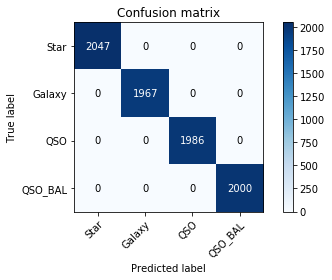

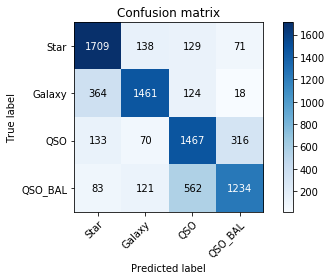

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

class_names=['Star','Galaxy','QSO','QSO_BAL']

def plot_confusion_matrix(y_true, y_pred, classes,normalize=False,title=None,cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plt.subplots(121)
#y_test=y_test.detach().numpy()
#y_pred=y_pred.detach().numpy()
#print(y_pred)
plot_confusion_matrix(y_test, y_test, classes=class_names, title='Confusion matrix')
plt.savefig('cm_train.png')
#plt.subplots(122)
plot_confusion_matrix(y_test, y_pred, classes=class_names, title='Confusion matrix')
plt.savefig('cm_test.png')

from sklearn.metrics import precision_recall_curve
p,r,f,s=precision_recall_fscore_support(y_test, y_pred, average=None)#,labels=['Star','Galaxy','QSO','QSO_BAL'])

print('Support:','Star:',round(s[0],4),'| Galaxy:',round(s[1],4),'| QSO:',round(s[2],4),'| QSO_BAL:',round(s[3],4))
print('Precision:','Star:',round(p[0],4),'| Galaxy:',round(p[1],4),'| QSO:',round(p[2],4),'| QSO_BAL:',round(p[3],4))
print('Recall:','Star:',round(r[0],4),'| Galaxy:',round(r[1],4),'| QSO:',round(r[2],4),'| QSO_BAL:',round(r[3],4))
print('F_score:','Star:',round(f[0],4),'| Galaxy:',round(f[1],4),'| QSO:',round(f[2],4),'| QSO_BAL:',round(f[3],4))


In [10]:
"""
classes = ('Star', 'Galaxy', 'QSO', 'QSO_BAL')
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(4):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

"""

"\nclasses = ('Star', 'Galaxy', 'QSO', 'QSO_BAL')\nclass_correct = list(0. for i in range(4))\nclass_total = list(0. for i in range(4))\nwith torch.no_grad():\n    for data in test_loader:\n        images, labels = data\n        outputs = net(images)\n        _, predicted = torch.max(outputs, 1)\n        c = (predicted == labels).squeeze()\n        for i in range(4):\n            label = labels[i]\n            class_correct[label] += c[i].item()\n            class_total[label] += 1\n\n\nfor i in range(4):\n    print('Accuracy of %5s : %2d %%' % (\n        classes[i], 100 * class_correct[i] / class_total[i]))\n\n"

In [ ]:
class Net_R(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(1, 100, 10,stride=2)
        self.conv2 = nn.Conv1d(100, 100, 10,stride=2)
        self.conv3 = nn.Conv1d(100, 100, 10,stride=2)
        self.conv4 = nn.Conv1d(100, 100, 10,stride=2)
        self.pool = nn.MaxPool1d(2, 1)
        self.fc1 = nn.Linear(1800, 16)
        #self.fc1 = nn.Linear(10300, 16)
        self.fc2 = nn.Linear(16, 4)


    def forward(self, x):
        in_size = x.size(0)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(in_size, -1)
        x = F.relu(self.fc1(x))        
        x = self.fc2(x)
        return F.log_softmax(x)


In [ ]:
X,y=Load_Files('truth_DR12Q.fits','data_dr12.fits',N_sample,classification=False)
train_loader,test_loader,val_loader=Loader(X,y,N_sample,epoc=10)

In [ ]:
net_R = Net_R()
print(net_R)

optimizer = torch.optim.SGD(net.parameters(), lr=0.2) #for Rgrss
loss_func = torch.nn.MSELoss()  

def train(epoch):
    #model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader,0):
        data, target = Variable(data), Variable(target)
       
        optimizer.zero_grad()
        
        output = net_C(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        print('Batch:',batch_idx,'<-->','Loss:',running_loss)
        #if(batch_idx !=0):    # print every 2000 mini-batches
            #print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 1000))
            #running_loss = 0.0
    


# Training loop
for i in range(epoc):
    print('Epoc:',i,'/n')
    train(i)
    
    
print('Finished Training')

In [ ]:
correct = 0
total = 0
d=[]
d1=[]
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        #print(predicted,predicted.shape)
        d.append(predicted)
        d1.append(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
#d=np.asarray(d)
print(d[0].shape)
print(d1[0].shape)
y_pred=torch.cat((d[0],d[1]),0)
y_test=torch.cat((d1[0],d1[1]),0)
print(y_pred.shape)